# Calculating sums and averages
Workflow that describes how to calculate the statistics of well logs in a set of intervals / zones, for a set of wells. The result is stored in a RokDoc *Sums and Averages* excel file, which can be used in RokDoc after converting the result file from *.xlsx* to *.xls*

In [4]:
import matplotlib.pyplot as plt
import os
import sys

working_dir = 'C:\\Users\\marten\\PycharmProjects\\blixt_rp'
sys.path.append(working_dir)

#the following two lines are only necessary when working with development versions of the code
sys.path.append('C:\\Users\\marten\\PycharmProjects\\blixt_rp')
sys.path.append('C:\\Users\\marten\\PycharmProjects\\blixt_utils')

import blixt_utils.io.io as uio
from blixt_rp.core.well import Project, Well
from blixt_rp.core.minerals import MineralMix
from blixt_rp.core.fluids import FluidMix
import blixt_rp.rp.rp_core as rp
import blixt_rp.plotting.plot_rp as prp
from blixt_rp.rp_utils.calc_stat_class import SetUpCalculation, CalculateStats

## Open a project
The project remembers where important information is stored, and controls the logging. More details about how to set up a project is found in *Introduction to blixt_rp.ipnb*. Now we use the local *MyProject.py* script, and use the shortcut defined there in *init()* to open an existing project, and load all wells, templates and working intervals.

In [5]:
import MyProject as mp
wp, wells, templates, wis = mp.init(working_dir, new=False)

c:\program files\python37\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


   # Calculate RokDoc compatible Sums & Averages
  This functionality is useful when you want to analyze the statistics of several formations / intervals across multiple wells.
  The results is saved as an .xlsx spreadsheet, with statistics of the rock properties. To be read by RokDoc, it has to be converted to .xls

If the .xlsx file exists, it will be appended to.



Modify the project_table.xlsx so that it points to the wells; Well_A, Well_B and Well_C

<img src="images/ProjectTable.png" />


Log names under each log types *P velocity*, *S velocity*, *Density*, *Porosity*, and *Volume* must be specified, else the output to RokDoc Sums and Averages will fail.

Multiple log names can be specified under each log type (e.g. *Vp* and *Vp_dry*), but only one log per log type can be used in the statistics.

Therefore we need a table to specify which log to use under each log type


In [7]:
log_table = {'P velocity': 'vp_dry', 'S velocity': 'vs_dry', 'Density': 'rho_dry', 'Porosity': 'phie', 'Volume': 'vcl'}

Determine which working intervals you'd like to calculate the statistics for

In [8]:
wi_sands = ['Sand H', 'Sand F', 'Sand E', 'Sand D', 'Sand C']
wi_shales = ['Shale G', 'Shale C']

Define the cut offs that are used to classify the data (e.g. sands or shales).
The statistics will only be calculated within each interval, where the cut off is valid
The log names (e.g. *vcl*) corresponding to a log type (e.g. *Volume*) must exist in the .las files

In [9]:
cutoffs_sands = {'Volume': ['<', 0.5], 'Porosity': ['>', 0.1]}
cutoffs_shales = {'Volume': ['>', 0.5], 'Porosity': ['<', 0.1]}

### Run the calculation of the statistics
*SetUpCalculation* is a class that collects a set of wells and a list of working intervals within which the statistics will be calculated. 

The list of cut offs, and log tables defines the log values that are used as input to the statistics.

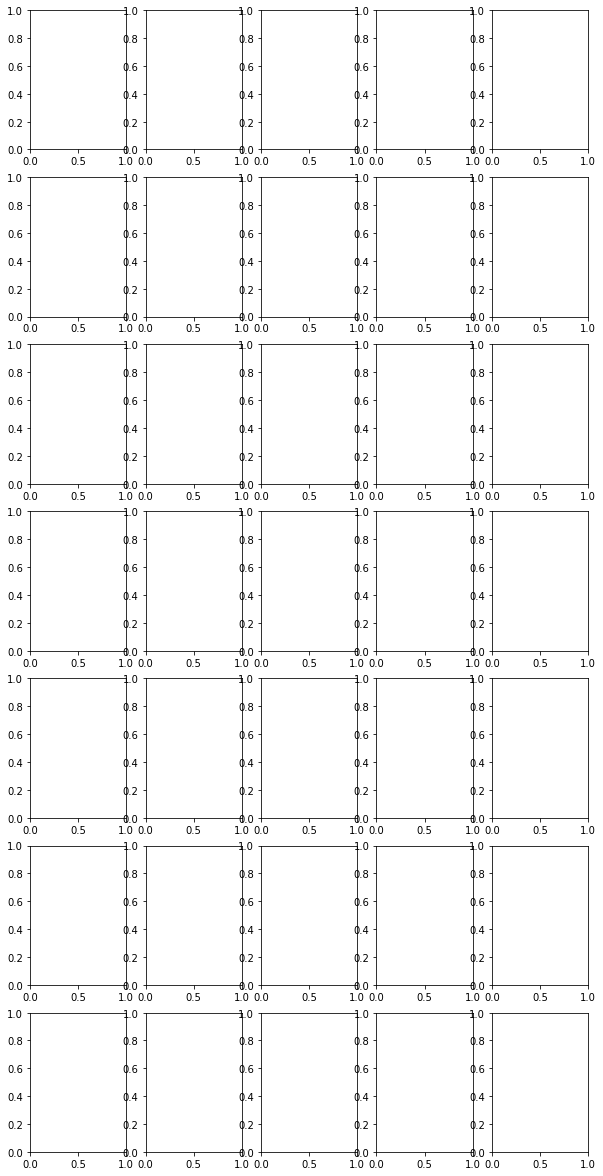

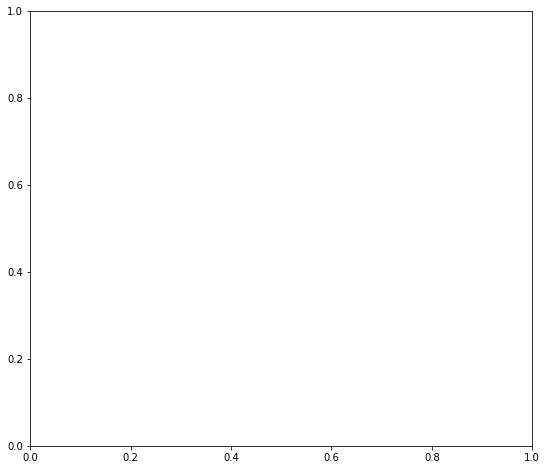

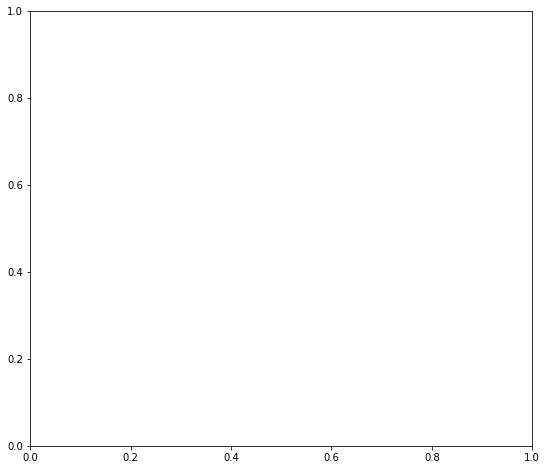

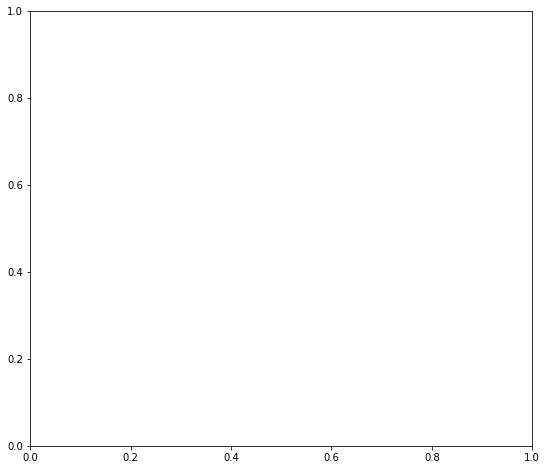

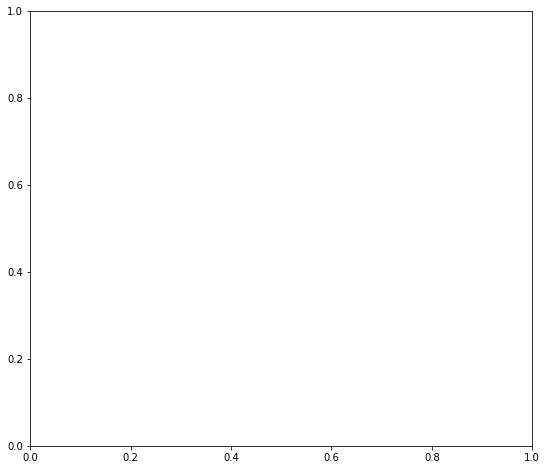

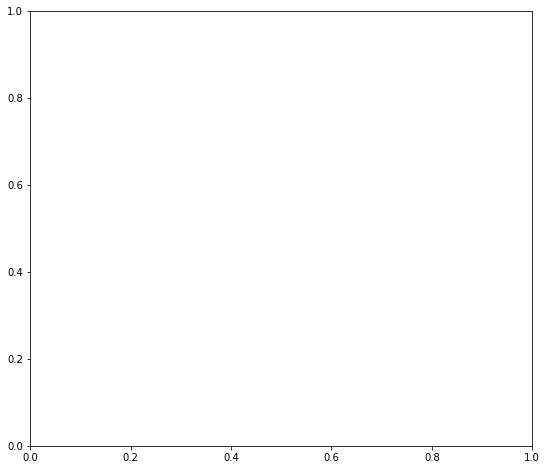

In [10]:
stats_set_up = SetUpCalculation(
    wells,
    ['Sand H', 'Sand F', 'Sand E', 'Sand D', 'Sand C', 'Shale G', 'Shale C'],
    [cutoffs_sands, cutoffs_sands, cutoffs_sands, cutoffs_sands, cutoffs_sands, cutoffs_shales, cutoffs_shales],
    [log_table, log_table, log_table, log_table, log_table, log_table, log_table],
    ['sand', 'sand', 'sand', 'sand', 'sand', 'shale', 'shale'],
    wis,
    templates,
    rokdoc_output=os.path.join(wp.working_dir, 'results_folder', 'SumsAndAverages_from_python.xlsx'),
    working_dir=os.path.join(wp.working_dir, 'results_folder')
)

Then the calculation is done upon this setup

In [11]:
stat_results = CalculateStats(stats_set_up)

Interval: Sand H
 sand. Volume<0.50, Porosity>0.10
Creating new RokDoc Sums and Averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Interval: Sand F
 sand. Volume<0.50, Porosity>0.10
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file


C:\Users\marten\PycharmProjects\blixt_rp\blixt_rp\rp_utils\calc_stat_class.py:114: RuntimeWarning: Mean of empty slice
  mn = np.nanmean(results_per_well[this_well_name][key])
C:\Users\marten\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\marten\PycharmProjects\blixt_rp\blixt_rp\rp_utils\calc_stats.py:1151: RuntimeWarning: Mean of empty slice
  np.nanmean(results[log_table['P velocity'].lower()]),
C:\Users\marten\PycharmProjects\blixt_rp\blixt_rp\rp_utils\calc_stats.py:1152: RuntimeWarning: Mean of empty slice
  np.nanmean(results[log_table['S velocity'].lower()]),
C:\Users\marten\PycharmProjects\blixt_rp\blixt_rp\rp_utils\calc_stats.py:1153: RuntimeWarning: Mean of empty slice
  np.nanmean(results[log_table['Density'].lower()]),
C:\Users\marten\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmea

Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Interval: Sand E
 sand. Volume<0.50, Porosity>0.10
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Interval: Sand D
 sand. Volume<0.50, Porosity>0.10
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Interval: Sand C
 sand. Volume<0.50, Porosity>0.10
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Appending to ex

Many plots are generated and saved in the specified working directory, that displays the results in different ways. 
A very useful plot is the following, which is generated for each log contained in the log_table:

<img src="images/P velocity.png" />

This shows the distribution of the log values (*P velocity* in this case) for each working interval, for each well and for all wells in conjunction.

The limits of the plot is determined by the Templates, and this case we can see that the range of P velocity should have been slightly lower.

In the resulting excel output, the statistics are collected first of all wells for each given working interval, then the for each well for each working interval: 

<img src="images/SumsAndAverages_1.png" />

And in the rightmost columns of the output excel file the logs and cutoffs are given, with the time of its calculation:

<img src="images/SumsAndAverages_2.png" />